## Library Setup

### Transformations
 - <mark>__Scale Down Ordinal Data By Substracting all samples with Global Feature Minimum__</mark>
 - <mark>__Sort Columns by Name for better visibility__</mark>
 - <mark>__Ordinally Encode Nominal Data to reduce categorical distance within a feature__</mark>
 - <mark>__Add a Column - Sum of all Binary Features along x-axis__</mark>
 - <mark>__Standardise the Ratio Features using MinMaxScaler__</mark>
 - <mark>__Group By binary Literal__</mark>
 - <mark>__Generated A Normal Rank for all Ordinal Features__</mark>
 - <mark>__Generated Dummy Variable for categoricals__</mark>
 - <mark>__Made all Type Conversions__</mark>


In [1]:
# import widen_notebook
from mysetup import NotebookFinder
import sys
sys.meta_path.append(NotebookFinder())

from setup_transform import *
%matplotlib inline
cl_weight = sklearn.utils.compute_class_weight(class_weight='balanced',classes=[0,1,2],y=y)
CLASS_WEIGHTS = {i:cl_weight[i] for i in range(3)}    
lgr_params = dict(class_weight=CLASS_WEIGHTS,fit_intercept=True,multi_class='ovr',max_iter=200000,random_state=42,n_jobs=24, penalty ='elasticnet' ,cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=5,random_state=30),scoring='f1_macro',solver='saga',Cs=100,l1_ratios= np.linspace(0,1,endpoint=False,num=10))
def_cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=2,random_state=42)
from sklearnex import unpatch_sklearn
# unpatch_sklearn()
import copy
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from setup_transform.ipynb


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Training

In [ ]:
raw_master = pd.concat([raw_data.loc[:,raw_data_eval.columns],raw_data_eval],ignore_index=True,axis=0)
vc_master = {x:raw_master[x].value_counts().to_dict() for x in nominal}
vc_train = {x:raw_data[x].value_counts().to_dict() for x in nominal}

def count_encode(row):
    for c in nominal:
        key = row[c]
        new_key = vc_master[c][key]
        row[c] = new_key
    return row

raw_master_ = raw_master.copy()
raw_data_ = raw_data.copy()
raw_data_eval_ = raw_data_eval.copy()
raw_data_.loc[:,nominal]=raw_data.loc[:,nominal].apply(count_encode,axis=1).astype('int')
raw_master_.loc[:,nominal]=raw_master.loc[:,nominal].apply(count_encode,axis=1).astype('int')
raw_data_eval_.loc[:,nominal]=raw_data_eval.loc[:,nominal].apply(count_encode,axis=1).astype('int')

def ordinal_encode_nominal(raw_master_,raw_data_,raw_data_eval_):
    ordinal_enc = OrdinalEncoder()
    ordinal_enc.fit(raw_master_.loc[:,nominal])
    raw_data_enc = ordinal_enc.transform(raw_data_.loc[:,nominal])
    raw_data_eval_enc = ordinal_enc.transform(raw_data_eval_.loc[:,nominal])
    raw_data_.loc[:,nominal] = raw_data_enc.astype('int')
    raw_data_eval_.loc[:,nominal] = raw_data_eval_enc.astype('int')
    return raw_master_,raw_data_,raw_data_eval_


# raw_master_,raw_data_,raw_data_eval_ = ordinal_encode_nominal(raw_master_,raw_data_,raw_data_eval_)

In [32]:
# raw_data_.loc[:,nominal]/5424
nominal_ohe_data = raw_data_ohe.loc[:,nominal_ohe]
class_labels = [0,1,2]
vc_i = {x:{} for x in range(3)}
for cl in class_labels:
    cp = raw_data[raw_data.target==cl]
    cn = raw_data[raw_data.target!=cl]
    vc_p = {x:{} for x in nominal }
    vc_n = {x:{} for x in nominal }
    for c in nominal:
        vc_p[c] = cp[c].value_counts().to_dict()        
        vc_n[c] = cn[c].value_counts().to_dict()
    vc_i[cl]['p'] = vc_p
    vc_i[cl]['n'] = vc_n
    

In [33]:
raw_data.target.value_counts()
N = raw_data.shape[0]
Np_Nn = {1:(1863,N-1863),2:(690,N-690),0:(1243,N-1243)}
for cl in vc_i:
    Np , Nn = Np_Nn[cl]
    # vc_i[cl]['p']
    for c in vc_i[cl]['p']:
        for k in vc_i[cl]['p'][c]:
            vc_i[cl]['p'][c][k] = vc_i[cl]['p'][c][k]/vc_train[c][k]
        for k in vc_i[cl]['n'][c]:
            vc_i[cl]['n'][c][k] = vc_i[cl]['n'][c][k]/vc_train[c][k]

In [35]:
for cl in vc_i:
    positive = vc_i[cl]['p']    
    negative = vc_i[cl]['n']


In [36]:
nominal_data

,nominal__v_12,nominal__v_18,nominal__v_20,nominal__v_21,nominal__v_25,nominal__v_3,nominal__v_32,nominal__v_4
id,,,,,,,,
0,0,25,17,0,4,10,0,18
1,6,74,49,5,3,119,33,28
2,0,25,95,0,0,20,74,76
3,0,18,0,0,0,44,0,57
4,6,51,44,1,42,33,11,6
...,...,...,...,...,...,...,...,...
3791,0,18,0,0,0,10,28,47
3792,9,24,4,4,5,33,2,66
3793,7,23,50,2,0,31,76,22


In [5]:
# X_dn.loc[:,nominal].unique()
"""
Omit Unseen Categories and set them to zero
"""
X_dn = raw_data.copy()
X_dn_eval  = raw_data_eval.copy()
omit_nominal = {x:[] for x in nominal}
for c in nominal:
    unq_train = raw_data[c].unique()    
    unq_eval = raw_data_eval[c].unique()
    uni = np.union1d(unq_train,unq_eval)
    inter = np.intersect1d(unq_train,unq_eval)
    omit_nominal[c] = list(np.setdiff1d(uni,inter,assume_unique=True))

def omit_nom(row):
    for c in nominal:
        if row[c] in omit_nominal[c]:
            row[c] = 0
    return row
X_dn = X_dn.apply(omit_nom,axis=1)
X_dn_eval = X_dn_eval.apply(omit_nom,axis=1)

X_master = pd.concat([X_dn.loc[:,X_dn_eval.columns],X_dn_eval],ignore_index=True,axis=0)
"""
Find Lowest Slot for infrequent Values
"""
unique_n = {}
for c in nominal:
    unique_n[c]  = X_master[c].unique().astype('int')

infreq_slot = {x:0 for x in nominal}

for c in unique_n:
    min_c = unique_n[c].min()    
    max_c = unique_n[c].max()
    c_range = np.arange(min_c,max_c,)
    infreq_slot[c] = np.setdiff1d(c_range,unique_n[c]).min()
    
"""
Find Lowest Infrequency Threshold
"""
vc_train = {x:X_dn[x].value_counts().to_dict() for x in nominal}
vc_eval = {x:X_dn_eval[x].value_counts().to_dict() for x in nominal}
infreq_threshold = {'train':{},'eval': {}}
f2 = 0.0
f1 = 0.006
for c in nominal:

    Tfreqs1 = list(vc_train[c].values())
    Tfreqs1 = sorted(set(Tfreqs1))
    infreq_threshold['train'][c] = min(0.005,Tfreqs1[12])
    if '12' in c or '21' in c:
        infreq_threshold['train'][c] = Tfreqs1[3]
        

        
    Tfreqs2 = list(vc_eval[c].values())
#     Tfreqs2 = sorted(Tfreqs2)
    Tfreqs2 = sorted(set(Tfreqs2))
    infreq_threshold['eval'][c] = Tfreqs2[6]
    if '12' in c or '21' in c or '4' in c:
        infreq_threshold['eval'][c] = Tfreqs2[3]

train_infreq = {x:[] for x in nominal}
eval_infreq = {x:[] for x in nominal}
selected_infreq = {x:[] for x in nominal}


"""
Find Infrequent Categories
"""

for c in nominal:
    for k in vc_train[c]:
        if vc_train[c][k] < infreq_threshold['train'][c]:
        # if vc_train[c][k] < 10:
            train_infreq[c].append(k)
    for k in vc_eval[c]:
        if vc_eval[c][k] < infreq_threshold['eval'][c]:
        # if vc_eval[c][k] < 5:
            eval_infreq[c].append(k)

for c in nominal:
    cmmn_infreq = np.union1d(train_infreq[c],eval_infreq[c])
    selected_infreq[c] = list(cmmn_infreq)
    
def mark_infreq_nom(row):
    for c in nominal:
        if row[c] in selected_infreq[c]:
            row[c] = infreq_slot[c]
    return row

X_dn = X_dn.apply(mark_infreq_nom,axis=1)
X_dn_eval = X_dn_eval.apply(mark_infreq_nom,axis=1)
def ohe(df):
    return pd.get_dummies(df.loc[:,nominal],columns=nominal)
vt = VarianceThreshold()
print(mutual_info_classif(vt.fit_transform(ohe(X_dn)),raw_data.target, random_state=42,discrete_features=True).mean() - mutual_info_classif(vt.fit_transform(ohe(raw_data)),raw_data.target, random_state=42,discrete_features=True).mean())

infreq_threshold

0.0005298962216687659


{'train': {'nominal__v_12': 9,
  'nominal__v_18': 14,
  'nominal__v_20': 15,
  'nominal__v_21': 11,
  'nominal__v_25': 15,
  'nominal__v_3': 13,
  'nominal__v_32': 14,
  'nominal__v_4': 13},
 'eval': {'nominal__v_12': 6,
  'nominal__v_18': 7,
  'nominal__v_20': 7,
  'nominal__v_21': 6,
  'nominal__v_25': 7,
  'nominal__v_3': 7,
  'nominal__v_32': 7,
  'nominal__v_4': 4}}

In [19]:
agg_tc =raw_data.groupby(['nominal__v_18'])['target'].value_counts().unstack().fillna(0).astype(np.uint16).sort_values(by=[1,0,2],ascending=False)
agg_tc

eval_freq  = raw_data_eval.nominal__v_18.value_counts()

agg_tc['eval'] = eval_freq
agg_tc['total_freq'] = agg_tc[0]+agg_tc[1]+agg_tc[2]
agg_tc = agg_tc.fillna(0).astype('int')
tmp: pd.DataFrame = agg_tc[agg_tc['eval'] ==0]
# tmp.filter
tmp
agg_tc[agg_tc['eval'] == 0]

agg_tc[agg_tc['total_freq']<=15]
agg_tc['t_e'] = agg_tc['eval']/agg_tc['total_freq']

# agg_tc[agg_tc['eval']==agg_tc['total_freq']]
agg_tc

In [47]:
import copy
discrete_ordinal = copy.deepcopy(ordinal)
discrete_ordinal.remove('ordinal__norm')

In [50]:
"""
Min Samples with all Categories
"""

X = raw_data.loc[:,nominal+discrete_ordinal]
cat_idx = {c:{} for c in nominal+discrete_ordinal}
for c in nominal+discrete_ordinal:
    categories = X[c].unique()
    for ca in categories:
        cat_idx[c][ca] = X[X[c]==ca].index
    # for c_ in discrete_ordinal:
from numpy.random import default_rng
def gen_rand_unique_idx(cat_idx):
    dfe1 = default_rng()
    m_idx = set()
    for c in cat_idx:
        for k,v in cat_idx[c].items():
            dfe = default_rng(seed=dfe1.integers(0,dfe1.integers(0,2121231212)))
            _ = dfe.choice(v,replace=False)
            # for e_ in _:
            m_idx.add(_)
    return m_idx
fin_idx = gen_rand_unique_idx(cat_idx)
for _ in range(100):
    tmp = gen_rand_unique_idx(cat_idx)
    fin_idx = fin_idx.intersection(tmp)
    
nw_X = X.loc[fin_idx,:]
for c in nominal+discrete_ordinal:
    tot = X[c].unique()
    av = nw_X[c].unique()
    miss = np.setdiff1d(tot,av)
    for m in miss:
        unc = np.setdiff1d(cat_idx[c][m],fin_idx)
        dfe = default_rng()
        ani  =dfe.choice(unc)
        fin_idx.add(ani)
len(fin_idx)


329

In [88]:
other = raw_data.index.difference(fin_idx)
X = pd.get_dummies(raw_data.loc[:,nominal+discrete_ordinal],columns=nominal+discrete_ordinal)
y = raw_data.target
X_train, X_test, y_train,y_test = gen_train_test(X.loc[other,:],y.loc[other],test_size=0.3)
X_train = X.loc[X_train.index.union(fin_idx),:]
y_train = y.loc[y_train.index.union(fin_idx)]
clf1 =  CategoricalNB(fit_prior=False,alpha = 1.0e-10,min_categories=2)
clf2_ = ComplementNB(alpha = 1.0e-10, fit_prior=True, norm=False)
clf2  = OneVsRestClassifier(clf2_,n_jobs=-1)
clf3_  = BernoulliNB(binarize=False,alpha = 1.0e-10,fit_prior=True)
clf3  = OneVsRestClassifier(clf3_,n_jobs=-1)
clf4_  = MultinomialNB(alpha = 1.0e-10,fit_prior=True)
clf4  = OneVsRestClassifier(clf4_,n_jobs=-1)


estimators = [
('cnb',clf1),
('comnb',clf2),
('bnb',clf3),
('mnb',clf4)
]
stc1 = StackingClassifier(estimators=estimators,final_estimator=LogisticRegressionCV(**lgr_params),n_jobs=-1)

In [89]:
with parallel_backend('threading'):
    stc1.fit(X_train,y_train)
    

In [104]:
y_pred = stc1.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       336
           1       0.83      0.72      0.77       514
           2       0.40      0.65      0.50       191

    accuracy                           0.68      1041
   macro avg       0.67      0.67      0.66      1041
weighted avg       0.73      0.68      0.70      1041



In [105]:
# stc1.estimators_[0].predict(X_test)
for clf in stc1.estimators_:
        clf.partial_fit(X.loc[fin_idx,:],y.loc[fin_idx],classes=[0,1,2])
        

        cv  = RepeatedStratifiedKFold(n_splits=10,n_repeats=50, random_state=42)

        for train_index, test_index in cv.split(X_train, y_train):
            X_train_, X_test_ = X.loc[train_index,:], X.loc[test_index,:]
            y_train_, y_test_ = y[train_index], y[test_index]
#             # print(X_train.shape)

            clf.partial_fit(X_train_,y_train_,classes=[0,1,2])   
            clf.partial_fit(X_test_,y_test_,classes=[0,1,2])
        # y_pred = clf.predict(X_test)
        # print(classification_report(y_test,y_pred))

In [113]:
ufo_val = {}
ufo_idx = None
cou = 0
for c in nominal+discrete_ordinal:
    i_ = raw_data[c].unique()
    i__ = raw_data_eval[c].unique()
    ufo = np.setdiff1d(i_,i__)
    ufo_val[c] = list(ufo)
    cou+=len(ufo)
    if len(ufo)>0:
        tmp = raw_data[raw_data[c]==list(ufo)[0]].index
        for val in list(ufo):
            tmp = tmp.union(raw_data[raw_data[c]==val].index)
            if type(ufo_idx) == pd.core.indexes.numeric.Int64Index:
                ufo_idx = ufo_idx.union(tmp)
            else:
                ufo_idx = tmp 

194

In [100]:
new_probs = stc1.transform(X_train)
stc1.final_estimator_.fit(new_probs,y_train)

LogisticRegressionCV(Cs=100,
                     class_weight={0: 1.0179672834540092, 1: 0.6791912685632492,
                                   2: 1.833816425120773},
                     cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=3, random_state=30),
                     l1_ratios=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                     max_iter=200000, multi_class='ovr', n_jobs=24,
                     penalty='elasticnet', random_state=42, scoring='f1_macro',
                     solver='saga')

In [ ]:
#     X_train2, X_valid, y_train2,y_valid = gen_train_test(X_train,y_train,test_size=0.3)
#     for clf in [clf1,clf2,clf3,clf4]:
#         clf.partial_fit(X.loc[fin_idx,:],y.loc[fin_idx],classes=[0,1,2])
        

#         cv  = RepeatedStratifiedKFold(n_splits=5,n_repeats=20, random_state=42)

#         for train_index, test_index in cv.split(X_train2, y_train2):
#             X_train_, X_test_ = X.loc[train_index,:], X.loc[test_index,:]
#             y_train_, y_test_ = y[train_index], y[test_index]
#             # print(X_train.shape)

#             clf.partial_fit(X_train_,y_train_,classes=[0,1,2])   
#             clf.partial_fit(X_test_,y_test_,classes=[0,1,2])
#         y_pred = clf.predict(X_test)
#         print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       335
           1       0.78      0.80      0.79       511
           2       0.48      0.50      0.49       192

    accuracy                           0.70      1038
   macro avg       0.66      0.66      0.66      1038
weighted avg       0.71      0.70      0.70      1038



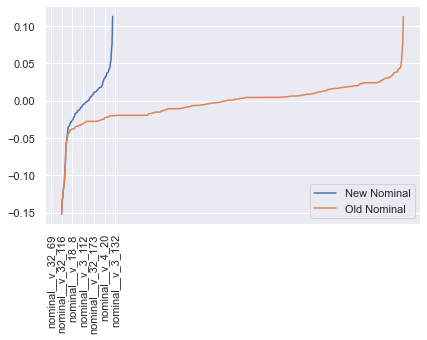

In [95]:
ohe(X_dn).corrwith(raw_data.target,method='kendall').sort_values().plot(rot=90, label='New Nominal')
_ = ohe(raw_data).corrwith(raw_data.target,method='kendall').sort_values().plot(rot=90,label='Old Nominal')

_ = plt.legend()

In [116]:
import copy
discrete_binary = copy.deepcopy(binary)
discrete_binary.remove('binary__sum')
discrete_binary.remove('binary__literal')
discrete_ordinal = copy.deepcopy(ordinal)
discrete_ordinal.remove('ordinal__norm')

In [7]:
(raw_data.target.value_counts()/3796).to_list()

[0.49077976817702845, 0.327449947312961, 0.18177028451001054]

In [111]:
# X_dn.loc[:,nominal].nunique().to_list()
discrete_ordinal = copy.deepcopy(ordinal)
discrete_ordinal.remove('ordinal__norm')
X = X_dn.loc[:,nominal]
min_categories = X.nunique().to_list()
min_categories

[16, 49, 54, 15, 44, 61, 51, 64]

In [18]:
clf = CategoricalNB(class_prior=np.array([0.49077976817702845, 0.327449947312961, 0.18177028451001054]),min_categories=[11, 10, 7, 11, 8, 13, 8, 17],alpha=0)

In [2]:


raw_data_ufo_train = 
raw_data_eval_ufo = 
